<a href="https://colab.research.google.com/github/jung-han-lee/Projects/blob/master/Models_Apple%26Samsung_Airing_Jung_Han_Lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn import metrics
import statistics
import math
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_apple = pd.read_excel('Airings-Report-Apple.xlsx'
                         , header=1, sheet_name='Brand Campaign Details')
df_samsung = pd.read_excel('Alphonso-Airings-Report-Samsung-20200302.xlsx'
                        , header=1, sheet_name='Brand Campaign Details')
df = pd.concat([df_apple, df_samsung])
df = df.reset_index(drop=True)

In [ ]:
df.shape

(16811, 23)

In [ ]:
df.tail()

,Id,Title,Brand,Product,Category,Network,Network Type,Show,Date,Time,...,Co-Op Product,Duration,EQ Units,Spend ($),Broadcast Year,Broadcast Month,Broadcast Week,Day Of Week,Hour Of Day,TimeZone
16806,4063180,Samsung Galaxy,Samsung,Samsung Galaxy,Electronics & Communication,FOX News Channel,cable,FOX and Friends,12/03/2019,7:16:42 AM,...,NaN,30,1.0,3491,2019,DEC,49,2,7,US/Eastern
16807,4063180,Samsung Galaxy,Samsung,Samsung Galaxy,Electronics & Communication,NBC,broadcast,Late Night With Seth Meyers,12/06/2019,1:27:27 AM,...,NaN,30,1.0,5257,2019,DEC,49,5,1,US/Eastern
16808,3861210,Samsung Galaxy Note 10,Samsung,Samsung Galaxy Note 10,Cell Phones,E!,cable,It's a Wonderful Life,12/25/2019,7:09:21 AM,...,NaN,30,1.0,2122,2019,DEC,52,3,7,US/Eastern
16809,3618599,Samsung Galaxy S10,Samsung,Samsung Galaxy S10,Cell Phones,FOX Sports 2,cable,FS1 College Football Playoff Preview,12/23/2019,11:41:32 PM,...,NaN,30,1.0,32,2019,DEC,52,1,23,US/Eastern
16810,3861210,Samsung Galaxy Note 10,Samsung,Samsung Galaxy Note 10,Cell Phones,CBS,broadcast,Carol's Second Act,12/25/2019,9:53:06 PM,...,NaN,30,1.0,109063,2019,DEC,52,3,21,US/Eastern


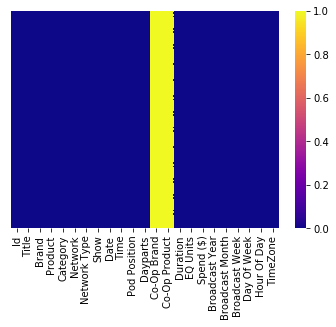

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False, cmap='plasma')

In [ ]:
# Dropped those columns since all of there values are NaN
df.drop(columns=['Co-Op Brand','Co-Op Product'], inplace=True)

In [ ]:
spend = df.pop('Spend ($)')
df['Cost']=spend 

In [ ]:
df.columns

Index(['Id', 'Title', 'Brand', 'Product', 'Category', 'Network',
       'Network Type', 'Show', 'Date', 'Time', 'Pod Position', 'Dayparts',
       'Duration', 'EQ Units', 'Broadcast Year', 'Broadcast Month',
       'Broadcast Week', 'Day Of Week', 'Hour Of Day', 'TimeZone', 'Cost'],
      dtype='object')

In [ ]:
df.drop(columns=['Date','Time'], inplace=True)
df[['Broadcast Year', 'Broadcast Week', 'Day Of Week', 'Hour Of Day']] = df[['Broadcast Year', 'Broadcast Week', 'Day Of Week', 'Hour Of Day']].astype(str)
df[['Pod Position']] = df[['Pod Position']].astype(str)
df[['Id']] = df[['Id']].astype(str)


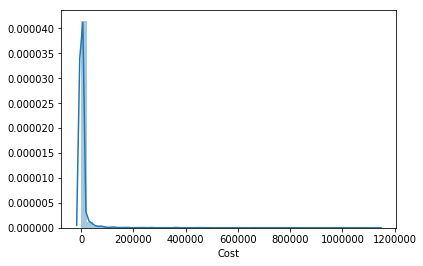

In [ ]:
sns.distplot(df['Cost'])

In [ ]:
df['Cost'].describe()

count    1.681100e+04
mean     7.592298e+03
std      4.009662e+04
min      0.000000e+00
25%      1.340000e+02
50%      5.690000e+02
75%      1.868000e+03
max      1.130473e+06
Name: Cost, dtype: float64

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df['Cost'].skew())
print("Kurtosis: %f" % df['Cost'].kurt())

Skewness: 11.859168
Kurtosis: 187.934735


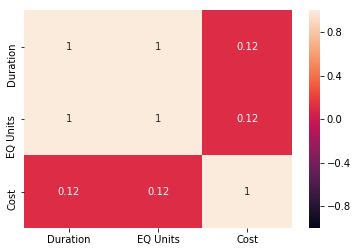

In [ ]:
corr = df.corr()
sns.heatmap(corr, vmin=-1, vmax=1,annot=True,annot_kws={'size': 10})

In [ ]:
#drop 'EQ Units'
df.drop(columns=['EQ Units'], inplace=True)

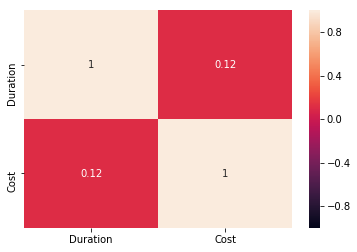

In [ ]:
corr = df.corr()
sns.heatmap(corr, vmin=-1, vmax=1,annot=True,annot_kws={'size': 10})

## Check correlation among categorical variables

In [ ]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [ ]:
def cat_corr(df):
    label = preprocessing.LabelEncoder()
    data_encoded = pd.DataFrame() 
    cats = ['Cost','Id','Title','Brand', 'Product','Pod Position', 'Category','Network','Network Type','Show','Dayparts'
       ,'Broadcast Year','Broadcast Month','Broadcast Week','Day Of Week','Hour Of Day','TimeZone']

    for i in cats :
        data_encoded[i]=label.fit_transform(df[i])
    
    rows= []

    for var1 in data_encoded:
        col = []
        for var2 in data_encoded :
            cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
            col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
        rows.append(col)

    
    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)
    return df

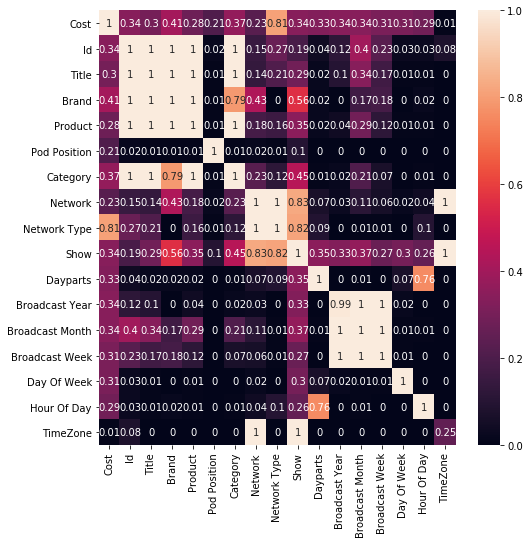

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cat_corr(df), annot=True,annot_kws={'size': 10})

In [ ]:
#Drop 'Id', 'Brand', 'Product', 'Category', 'Network Type', 'Broadcast Month' and 'TimeZone'
df.drop(columns=['Id','Brand', 'Product', 'Category', 'Network Type', 'TimeZone', 'Broadcast Year','Broadcast Month'], inplace=True)

## Log Transformation : Cost

In [ ]:
df['Cost_log']=np.log(df['Cost'])

## Outliers detection

(-0.5, 6.5, 0, 20)

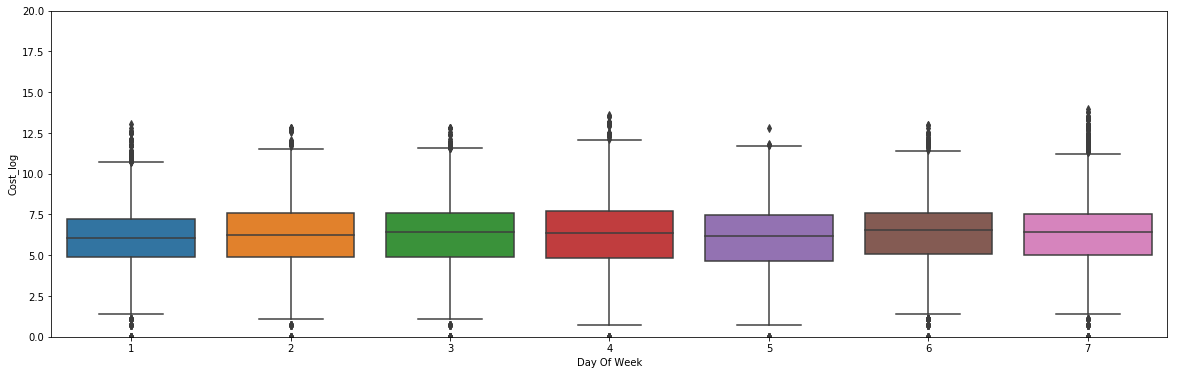

In [ ]:
#box plot Day of Week/cost
var = 'Day Of Week'
data = pd.concat([df['Cost_log'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x=var, y="Cost_log", data=data)
fig.axis(ymin=0, ymax=20)

From the above chart, I can say that no need to remove any data.

## Categorize the 'Cost' Variable : For Classification Modeling

In [ ]:
Cost_cat = []
for cost in df.Cost:
    if cost < 10000:
        Cost_cat.append('Under 10k')
    elif cost<100000:
        Cost_cat.append('10k')
    elif cost<100000:
        Cost_cat.append('100k')
    else:
        Cost_cat.append('Over 100k')
df['Cost_cat'] = Cost_cat

In [ ]:
df.head(3)

,Title,Network,Show,Pod Position,Dayparts,Duration,Broadcast Week,Day Of Week,Hour Of Day,Cost,Cost_log,Cost_cat
0,Apple Music Bazzi,MTVU,mtvU Music Block,2,PRIME TIME,30,42,4,21,1,0.000000,Under 10k
1,Apple iPhone 11 Pro,MLB Network,MLB Tonight,2,PRIME ACCESS,30,41,5,19,810,6.697034,Under 10k
2,Verizon With Apple Music,ESPN Deportes,Fútbol picante,6,OVERNIGHT,30,41,1,3,6,1.791759,Under 10k


## Dummy Coding

In [ ]:
df_dummy = pd.get_dummies(df, columns=['Title', 'Network', 'Show', 'Pod Position','Dayparts',
                                       'Broadcast Week','Day Of Week','Hour Of Day'], drop_first=True)

In [ ]:
df_dummy.shape

(16811, 1964)

In [ ]:
df_dummy['Cost_log']

0         0.000000
1         6.697034
2         1.791759
3         6.921658
4         7.826842
           ...    
16806     8.157944
16807     8.567316
16808     7.660114
16809     3.465736
16810    11.599681
Name: Cost_log, Length: 16811, dtype: float64

In [ ]:
delete_row = df_dummy[df_dummy["Cost_log"]==float('-inf')].index
df_dummy = df_dummy.drop(delete_row)
df_dummy = df_dummy.reset_index(drop=True)

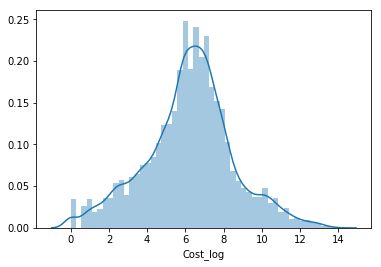

In [ ]:
sns.distplot(df_dummy['Cost_log'])

## Scale

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
y = df_dummy.Cost_log
x = df_dummy.drop(columns=["Cost", "Cost_log", "Cost_cat"], axis = 1)

In [ ]:
x.head()

,Duration,Title_Apple,"Title_Apple ""Share Your Gifts""",Title_Apple App Store,Title_Apple Behind The Mac,Title_Apple Card,Title_Apple HomePod,Title_Apple IPhone 11 Pro,Title_Apple IPhone 11Pro,Title_Apple Mac mini,...,Hour Of Day_21,Hour Of Day_22,Hour Of Day_23,Hour Of Day_3,Hour Of Day_4,Hour Of Day_5,Hour Of Day_6,Hour Of Day_7,Hour Of Day_8,Hour Of Day_9
0,30,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
scaler.fit(x)
scaled_x = x.copy()
scaled_x.iloc[:] = scaler.transform(x)

In [ ]:
scaled_x.head()

,Duration,Title_Apple,"Title_Apple ""Share Your Gifts""",Title_Apple App Store,Title_Apple Behind The Mac,Title_Apple Card,Title_Apple HomePod,Title_Apple IPhone 11 Pro,Title_Apple IPhone 11Pro,Title_Apple Mac mini,...,Hour Of Day_21,Hour Of Day_22,Hour Of Day_23,Hour Of Day_3,Hour Of Day_4,Hour Of Day_5,Hour Of Day_6,Hour Of Day_7,Hour Of Day_8,Hour Of Day_9
0,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,3.607404,-0.258544,-0.23332,-0.184466,-0.136767,-0.152452,-0.163935,-0.174558,-0.170343,-0.181333
1,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.277208,-0.258544,-0.23332,-0.184466,-0.136767,-0.152452,-0.163935,-0.174558,-0.170343,-0.181333
2,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.277208,-0.258544,-0.23332,5.421041,-0.136767,-0.152452,-0.163935,-0.174558,-0.170343,-0.181333
3,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.277208,-0.258544,-0.23332,-0.184466,-0.136767,-0.152452,-0.163935,-0.174558,-0.170343,-0.181333
4,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.277208,-0.258544,-0.23332,-0.184466,-0.136767,-0.152452,-0.163935,-0.174558,5.870520,-0.181333


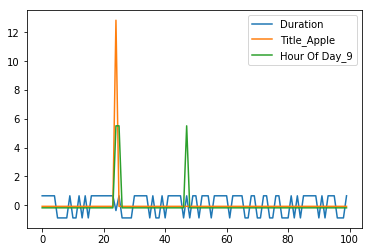

In [ ]:
plt.plot(scaled_x.iloc[:100,0])
plt.plot(scaled_x.iloc[:100,1])
plt.plot(scaled_x.iloc[:100,-1])
plt.legend(['Duration ','Title_Apple ','Hour Of Day_9'])

In [ ]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(scaled_x, y, test_size=0.2, random_state=0)

## Dimension Reduction : Principal Component Analysis

In [ ]:
import sklearn.decomposition as skd
pca = skd.PCA()
pca_model=pca.fit(x_train_scaled)

### How much of the variance does each component explain?

In [ ]:
pca_model.components_.shape

(1961, 1961)

In [ ]:
pca_model.explained_variance_

array([3.65466038e+00, 3.55385631e+00, 3.53518377e+00, ...,
       1.44816598e-32, 6.23927406e-33, 2.07315002e-34])

### What would be an appropriate number of components to keep?

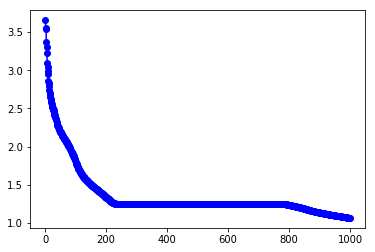

In [ ]:
plt.plot(range(1,1000),pca_model.explained_variance_[:999],'b-o')

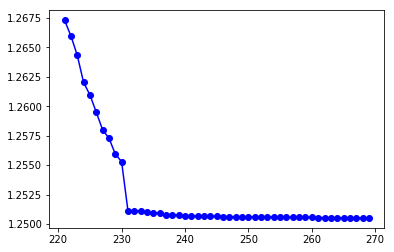

In [ ]:
plt.plot(range(221,270),pca_model.explained_variance_[220:269],'b-o')

The improvements will decline, at some point rapidly, creating the elbow shape.

That point is the optimal value for K. In the image above, K=230. So, the appropriate number of components is 230.

### Exploratory Factor Analysis

In [ ]:
fa_model = skd.FactorAnalysis(n_components=230).fit(x_train_scaled)

In [ ]:
df_fa=pd.DataFrame(fa_model.components_[:230,:].T, 
             index=x_train_scaled.columns)

In [ ]:
df_fa.head()

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,229
Duration,-0.010903,3.751090e-02,-0.019129,-0.036208,9.683816e-03,4.000566e-06,-2.165409e-02,3.745455e-04,0.075306,1.565158e-07,...,0.000374,0.000746,0.000594,-0.001331,-0.001441,0.000841,-0.000884,0.001100,-0.000010,-0.000983
Title_Apple,-0.000232,-1.987467e-09,0.000153,-0.000100,-2.058906e-09,-1.025625e-10,-3.836332e-11,-9.125026e-11,-0.003133,-3.350331e-09,...,0.014554,-0.031646,-0.007964,0.016065,0.023196,0.016790,-0.015265,-0.017912,-0.022974,-0.037312
"Title_Apple ""Share Your Gifts""",-0.000065,4.748237e-10,0.000043,-0.000028,-2.862544e-10,-9.284559e-11,5.221770e-12,-1.621912e-11,-0.000880,-7.223911e-10,...,-0.000345,-0.000191,0.000979,0.001037,0.000013,0.000060,-0.000685,0.000090,0.000095,0.000588
Title_Apple App Store,-0.000098,-2.922583e-09,0.000065,-0.000042,-6.890979e-10,9.511080e-11,2.125935e-12,2.758412e-12,-0.001323,-1.142716e-09,...,0.000138,-0.000053,-0.000180,-0.000057,0.000094,-0.000071,0.000016,-0.000042,0.000093,-0.000021
Title_Apple Behind The Mac,0.016177,-1.045792e-06,0.037707,-0.075509,-8.879288e-02,-2.916384e-05,-9.924829e-02,1.718060e-03,0.076358,-2.263213e-09,...,0.000125,0.000196,0.000321,-0.000011,-0.000016,-0.000078,-0.000096,-0.000074,-0.000094,0.000198


In [ ]:
factors = skd.FactorAnalysis(230).fit_transform(x_train_scaled)

In [ ]:
df_fa_ = pd.concat([x_train_scaled, pd.DataFrame(factors)], axis=1)

In [ ]:
df_fa_.head()

,Duration,Title_Apple,"Title_Apple ""Share Your Gifts""",Title_Apple App Store,Title_Apple Behind The Mac,Title_Apple Card,Title_Apple HomePod,Title_Apple IPhone 11 Pro,Title_Apple IPhone 11Pro,Title_Apple Mac mini,...,220,221,222,223,224,225,226,227,228,229
0,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.451472,0.316971,-1.538880,-1.805150,0.203476,0.092058,-0.685956,-1.211331,-1.132337,0.498939
1,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.294027,-0.191938,0.024471,-0.372344,0.579024,-0.325927,-0.079047,-0.046548,0.358807,-0.263176
2,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,0.456845,0.101553,0.115915,-0.825851,0.187337,0.628371,-0.883922,0.255762,0.433678,0.164757
3,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,0.490313,-0.331621,0.125906,-0.300132,-0.297905,0.014429,0.061394,0.166480,-0.426406,-0.064282
4,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.449411,0.537947,-0.432909,-0.185269,0.877523,0.039390,0.141497,0.333703,-0.397943,0.632220


In [ ]:
fa_cor = df_fa_.corr()[df_fa_.columns[-230:]]

In [ ]:
#Extract the original variables which have the value of correlation 
#higher than 0.5 with each factor(In factor analysis model)
for c in fa_cor.columns:
    a=[]
    for i in fa_cor.index:
        if abs(fa_cor.loc[i,c])>0.5:
            a.append(i)
    print(c,a)

0 [0]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [7]
8 [8]
9 [9]
10 [10]
11 [11]
12 [12]
13 [13]
14 ['Show_A Very Vintage Christmas', 14]
15 [15]
16 [16]
17 [17]
18 ['Show_A Very Vintage Christmas', 18]
19 [19]
20 [20]
21 ['Show_Lights Out With David Spade', 21]
22 [22]
23 [23]
24 [24]
25 [25]
26 [26]
27 [27]
28 [28]
29 [29]
30 [30]
31 [31]
32 [32]
33 [33]
34 [34]
35 [35]
36 [36]
37 [37]
38 [38]
39 [39]
40 [40]
41 [41]
42 [42]
43 [43]
44 [44]
45 ['Show_Afternoon Bonus Coverage', 45]
46 [46]
47 [47]
48 [48]
49 [49]
50 [50]
51 [51]
52 [52]
53 [53]
54 [54]
55 [55]
56 [56]
57 [57]
58 [58]
59 [59]
60 [60]
61 [61]
62 [62]
63 [63]
64 [64]
65 [65]
66 [66]
67 [67]
68 [68]
69 [69]
70 [70]
71 [71]
72 [72]
73 [73]
74 [74]
75 [75]
76 [76]
77 [77]
78 [78]
79 [79]
80 [80]
81 [81]
82 [82]
83 [83]
84 [84]
85 [85]
86 [86]
87 [87]
88 [88]
89 [89]
90 [90]
91 [91]
92 [92]
93 [93]
94 [94]
95 [95]
96 [96]
97 [97]
98 [98]
99 [99]
100 [100]
101 [101]
102 [102]
103 [103]
104 [104]
105 [105]
106 [106]
107 [107]
108 [

As we can find from above, it is hard to find relationships between original features and features from EFA.

Therefore, I will use 230 as the optimal number of components for dimension reduction.

In [ ]:
pca_model = skd.PCA(n_components=230).fit(x_train_scaled)
df_pca=pd.DataFrame(pca_model.components_[:230,:].T, 
             index=x_train_scaled.columns)

In [ ]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,229
Duration,0.248367,0.144296,-0.150789,-0.092840,0.011368,0.068860,0.120339,0.005703,0.029372,0.025613,...,0.011065,0.000844,-0.001267,0.001482,-0.002328,-0.000126,-0.004712,0.002088,0.003626,0.002885
Title_Apple,-0.008095,-0.007351,0.005608,-0.011822,0.001760,-0.003295,0.012509,0.003528,-0.001476,-0.021050,...,-0.001509,-0.012990,-0.025534,-0.006938,-0.012641,0.018141,0.014357,-0.007921,0.027551,0.005470
"Title_Apple ""Share Your Gifts""",0.010323,0.001705,-0.005517,-0.002957,0.000220,0.005407,0.010999,0.003717,0.021000,-0.000667,...,0.010707,0.007928,0.013420,-0.004691,-0.009697,0.014297,-0.000518,0.014093,-0.000506,-0.012689
Title_Apple App Store,-0.002674,-0.016399,0.006184,-0.002464,0.001233,-0.008983,-0.000114,-0.005514,0.001490,0.017996,...,-0.002020,0.000632,0.000893,0.002521,0.000027,0.000471,-0.000569,0.001202,0.000117,-0.000116
Title_Apple Behind The Mac,0.077660,0.013263,0.010532,-0.002849,0.000132,0.064095,0.197941,-0.011182,0.444098,-0.028594,...,0.004506,-0.003484,0.007685,0.001454,-0.007951,0.001407,-0.000036,0.004161,0.002753,0.004313


### Compressed dataset for Regression models

In [ ]:
pca_train = skd.PCA(n_components=230).fit_transform(x_train_scaled)

df_pca_train=pd.DataFrame(pca_train)

pca_test = skd.PCA(n_components=230).fit_transform(x_test_scaled)

df_pca_test=pd.DataFrame(pca_test)

y_train_pca, y_test_pca = y_train_scaled, y_test_scaled

# Part 1: Regression Modeling

In [ ]:
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y, test_size=0.2, random_state=0)

# 1.1. Linear Regression

In [ ]:
regressor = LinearRegression() 
regressor.fit(x_train_reg, y_train_reg)

LinearRegression()

### Compare the actual 'Cost' and the predicted value of 'Cost'

In [ ]:
y_pred_reg = regressor.predict(x_test_reg)
df_reg = pd.DataFrame({'Actual': y_test_reg, 'Predicted': y_pred_reg})
df_reg.head(10)

,Actual,Predicted
14868,8.356555,8.550338
14301,5.863631,6.017879
9691,1.609438,2.371875
6274,4.418841,4.709358
12593,5.398163,4.628446
51,6.122493,6.264700
1963,6.167516,5.624810
11503,5.924256,6.121684
5334,4.709530,4.957455
13206,6.608001,6.107259


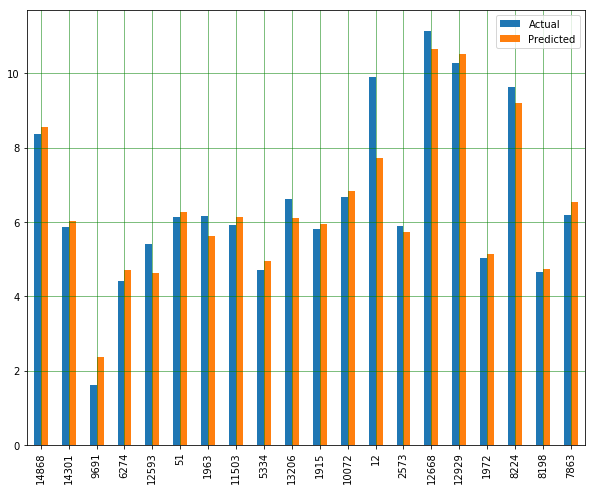

In [ ]:
df1=df_reg.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Calculate the error for log-Cost

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_reg))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_reg))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_reg)))

Mean Absolute Error: 20136.824642544896
Mean Squared Error: 42587335080.531166
Root Mean Squared Error: 206366.99125715616


In [ ]:
for i in y_pred_reg:
    if abs(i)>1000:
        print(i)

-106268.7699361234
1437535.5463056215
574389.440112351
1911021.8850140828
-649461.9832710982
-17184.40529868938
3537799.601967462
-854940.8427665639
-975784.1627658769
-35474.10618975712
-960960.368653472
942210.8375943252
141727.29576646816
348178.7494664956
-191686.7499329145
1372296.9246389158
-672047.4555262248
1437533.7666896894
797135.2760378853
2386292.8736705747
-661491.9140514
-375189.8798205382
-804556.6626935429
2386292.578481203
1437533.260797069
7496248.256232776
906431.552934486
-189985.35812638002
1761190.5252627274
517924.4137957231
-624300.2209767974
-1954019.0812358647
1330995.4715659958
-624300.8473798535
931773.3116499712
831415.1897899378
-191686.8981937277
942208.456667088
-1045776.6896928544
-1045774.3351783226
-1730059.2741919258
1437533.8801835203
178673.31671030493
-364214.9472776954
-357753.89133039257
-1045776.5679113311
-187898.01602673111
-960961.8963639778
1437534.8607486375
-1220601.7790183998
255164.3252317109
166511.84329531435
1426304.8533219625
52443

In [ ]:
prediction_reg = regressor.predict(x_train_reg)

Text(0.5, 1.0, 'Normal Q-Q Plot')

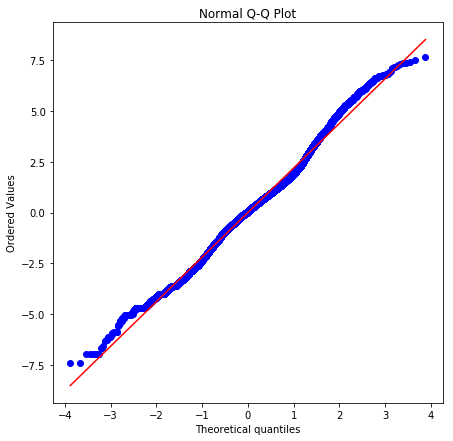

In [ ]:
residuals_reg = y_train_reg - prediction_reg.reshape(-1)

plt.figure(figsize=(7,7))
stats.probplot(residuals_lasso, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

In [ ]:
idx_reg=list(y_test_reg.index)

### Retransform the log transformed 'Cost' : Smear Factor

In [ ]:
std_reg = statistics.stdev(y_pred_reg)
y_pred_reg_real = list(map(lambda x: math.exp(x + 0.5*std_reg**2), y_pred_reg ))
y_test_reg_real = df_dummy.Cost.iloc[idx_reg]

Since the residuals are nearly normally distributed, I retrandsformed log-cost with not only using the variation of the data.

### Calculate the error for retransformed Cost

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_ridge_real, y_pred_ridge_real))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_ridge_real, y_pred_ridge_real))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_ridge_real, y_pred_ridge_real)))

Mean Absolute Error: 3572.7038102335982
Mean Squared Error: 361304870.2505872
Root Mean Squared Error: 19008.02120817912


The errorwas much bigger than I expected. 

Therefore, I plan to try some feature selection via Lasso, Ridge, and Elastic Net regression mothods

# 1.2. Lasso

In [ ]:
regressor_lasso = Lasso(alpha=1.0,max_iter=1000, tol=0.0001)

In [ ]:
regressor_lasso.fit(x_train_reg, y_train_reg)

Lasso()

### Find coefficients for the model

In [ ]:
coeff_df = pd.DataFrame(regressor_lasso.coef_, x.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Id,0.000006
Duration,0.022363
Title_Apple,0.000000
"Title_Apple ""Share Your Gifts""",0.000000
Title_Apple App Store,0.000000
...,...
Hour Of Day_5,-0.000000
Hour Of Day_6,-0.000000
Hour Of Day_7,-0.000000
Hour Of Day_8,-0.000000


### Compare the actual 'Cost' and the predicted value of 'Cost'

In [ ]:
y_pred_lasso = regressor_lasso.predict(x_test_reg)
df_lasso = pd.DataFrame({'Actual': y_test_reg, 'Predicted': y_pred_lasso})
df_lasso.head(10)

,Actual,Predicted
14868,8.356555,5.674582
14301,5.863631,6.517447
9691,1.609438,4.693742
6274,4.418841,5.916408
12593,5.398163,5.745828
51,6.122493,6.183766
1963,6.167516,6.323202
11503,5.924256,5.712390
5334,4.709530,6.592135
13206,6.608001,5.972632


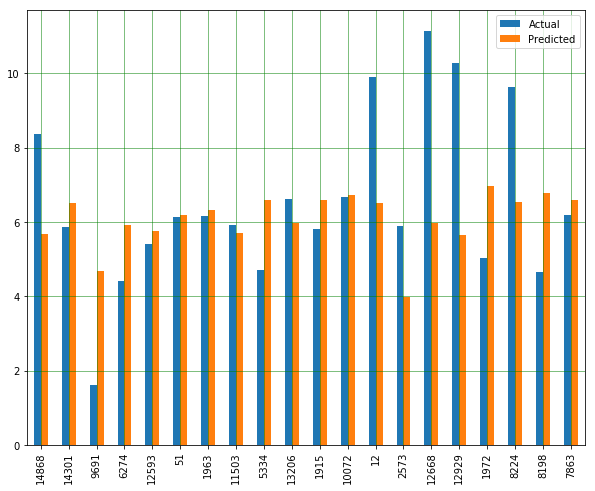

In [ ]:
df1=df_lasso.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Calculate the error for log-Cost

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_lasso))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_lasso))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_lasso)))

Mean Absolute Error: 1.701993713964688
Mean Squared Error: 4.8484045734376275
Root Mean Squared Error: 2.2019093018191342


Compare to the Linear Regression model, Lasso model has much smaller error.

In [ ]:
prediction_lasso = regressor_lasso.predict(x_train_reg)

Text(0.5, 1.0, 'Normal Q-Q Plot')

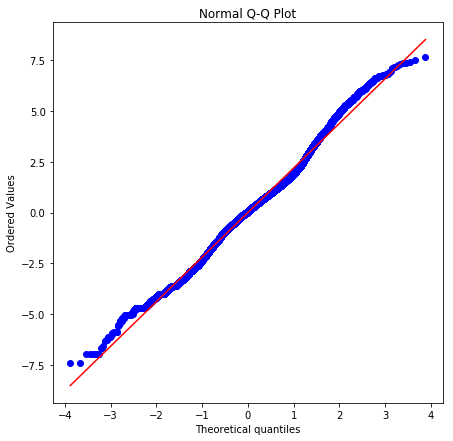

In [ ]:
import scipy.stats as stats
residuals_lasso = y_train_reg - prediction_lasso.reshape(-1)

plt.figure(figsize=(7,7))
stats.probplot(residuals_lasso, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

Residuals are nearly normally distributed.

### Retransform the log transformed 'Cost' : Smear Factor

In [ ]:
std_lasso = statistics.stdev(y_pred_lasso)

In [ ]:
y_pred_lasso_real = list(map(lambda x: math.exp(x + 0.5*std_lasso**2), y_pred_lasso ))

In [ ]:
y_test_lasso_real = df_dummy.Cost.iloc[idx_reg]

### Calculate the error for retransformed Cost

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_lasso_real, y_pred_lasso_real))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_lasso_real, y_pred_lasso_real))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_lasso_real, y_pred_lasso_real)))

Mean Absolute Error: 7193.341736987032
Mean Squared Error: 1285621761.2116323
Root Mean Squared Error: 35855.568064271865


# 1.3. Ridge

In [ ]:
regressor_ridge = Ridge(alpha=1.0,tol=0.001, solver='auto')

In [ ]:
regressor_ridge.fit(x_train_reg, y_train_reg)

Ridge()

### Compare the actual 'Cost' and the predicted value of 'Cost'

In [ ]:
y_pred_ridge = regressor_ridge.predict(x_test_reg)
df_ridge = pd.DataFrame({'Actual': y_test_reg, 'Predicted': y_pred_ridge})
df_ridge.head(10)

,Actual,Predicted
14868,8.356555,8.559191
14301,5.863631,6.044780
9691,1.609438,2.375650
6274,4.418841,4.840814
12593,5.398163,4.708962
51,6.122493,6.322903
1963,6.167516,5.571626
11503,5.924256,6.064426
5334,4.709530,4.855263
13206,6.608001,6.161072


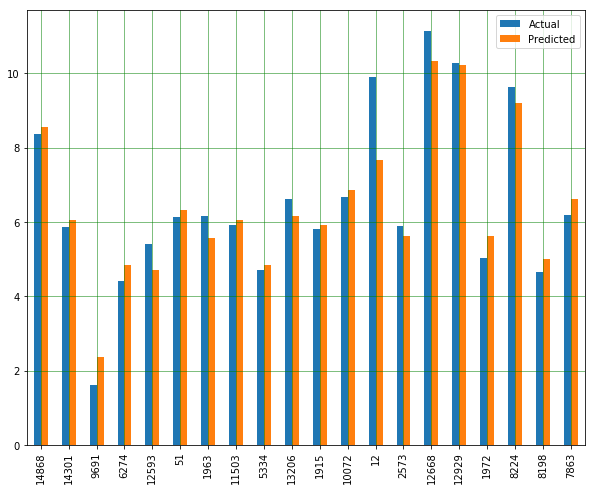

In [ ]:
df1=df_ridge.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Calculate the error for log-Cost


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_ridge))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_ridge))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_ridge)))

Mean Absolute Error: 0.4394722207345003
Mean Squared Error: 0.3578269271517539
Root Mean Squared Error: 0.5981863648995637


Ridge model has a better result compare to Lasso model!

In [ ]:
prediction_ridge = regressor_ridge.predict(x_train_reg)

Text(0.5, 1.0, 'Normal Q-Q Plot')

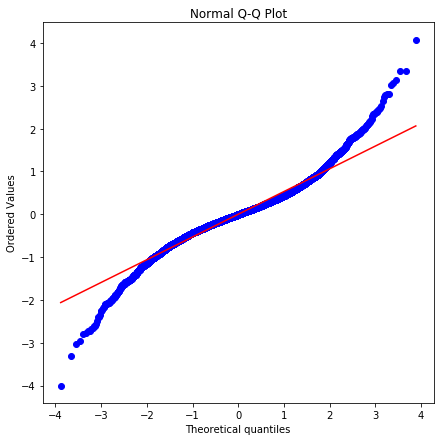

In [ ]:
residuals_ridge = y_train_reg - prediction_ridge.reshape(-1)

plt.figure(figsize=(7,7))
stats.probplot(residuals_ridge, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

The residuals from Ridge model are not normally distributed. It seems more like fat tail distribution!

Therefore, I tried emprical way to find the best result.

### Retransform the log transformed 'Cost' : Smear Factor

In [ ]:
std_ridge = statistics.stdev(y_pred_ridge)
y_pred_ridge_real = list(map(lambda x: math.exp(x - 0.1*std_lasso**2), y_pred_ridge ))
y_test_ridge_real = df_dummy.Cost.iloc[idx_reg]

### Calculate the error for retransformed Cost

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_ridge_real, y_pred_ridge_real))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_ridge_real, y_pred_ridge_real))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_ridge_real, y_pred_ridge_real)))

Mean Absolute Error: 3572.7038102335982
Mean Squared Error: 361304870.2505872
Root Mean Squared Error: 19008.02120817912


# 1.4. Elastic Net

In [ ]:
regressor_net = ElasticNet(alpha=1.0,l1_ratio=0.5, tol=0.0001)

In [ ]:
regressor_net.fit(x_train_reg, y_train_reg)

ElasticNet()

### Compare the actual 'Cost' and the predicted value of 'Cost'

In [ ]:
y_pred_net = regressor_net.predict(x_test_reg)
df_net = pd.DataFrame({'Actual': y_test_reg, 'Predicted': y_pred_ridge})
df_net.head(10)

,Actual,Predicted
14868,8.356555,8.559191
14301,5.863631,6.044780
9691,1.609438,2.375650
6274,4.418841,4.840814
12593,5.398163,4.708962
51,6.122493,6.322903
1963,6.167516,5.571626
11503,5.924256,6.064426
5334,4.709530,4.855263
13206,6.608001,6.161072


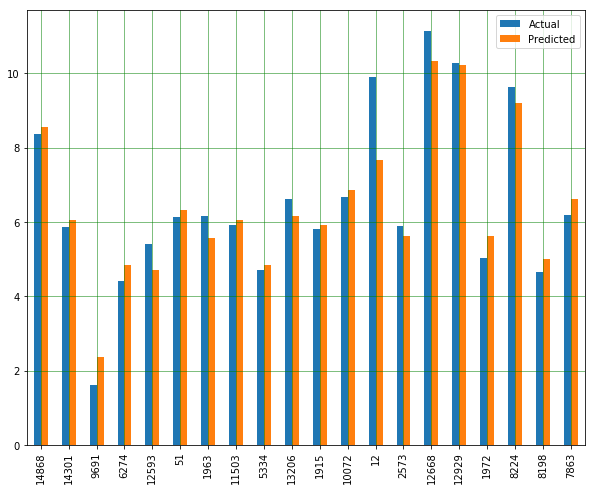

In [ ]:
df1=df_net.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Calculate the error for log-Cost


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_net))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_net))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_net)))

Mean Absolute Error: 1.6996209652113214
Mean Squared Error: 4.838866508519041
Root Mean Squared Error: 2.1997423732153365


In [ ]:
prediction_net = regressor_net.predict(x_train_reg)

Text(0.5, 1.0, 'Normal Q-Q Plot')

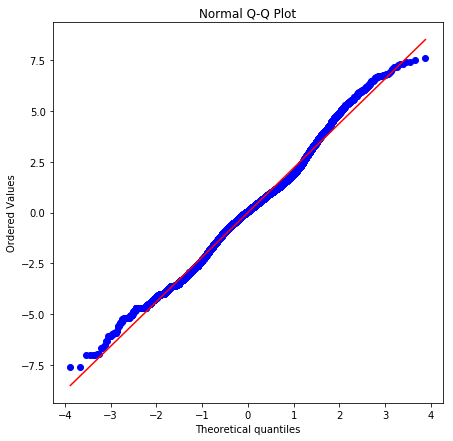

In [ ]:
import scipy.stats as stats
residuals_net = y_train_reg - prediction_net.reshape(-1)

plt.figure(figsize=(7,7))
stats.probplot(residuals_net, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

### Retransform the log transformed 'Cost' : Smear Factor


In [ ]:
std_net = statistics.stdev(y_pred_net)
y_pred_net_real = list(map(lambda x: math.exp(x + 0.5*std_net**2), y_pred_net ))
y_test_net_real = df_dummy.Cost.iloc[idx_reg]

### Calculate the error for retransformed Cost

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_net_real, y_pred_net_real))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_net_real, y_pred_net_real))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_net_real, y_pred_net_real)))

Mean Absolute Error: 7189.434321162769
Mean Squared Error: 1284621554.6672354
Root Mean Squared Error: 35841.617634633


# 1.5. RandomForest Regression

In [ ]:
train_features_reg, test_features_reg, train_labels_reg, test_labels_reg = train_test_split(x, y,
                                                                                            test_size=0.2, 
                                                                                            random_state=42)

### Train Model

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features_reg, train_labels_reg)

RandomForestRegressor(n_estimators=1000, random_state=42)

### Make predictions on the test sets

In [ ]:
# Use the forest's predict method on the test data
predictions_rfr = rf.predict(test_features_reg)
# Calculate the absolute errors
errors = abs(predictions_rfr - test_labels_reg)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.36 degrees.


### Compare the actual 'Cost' and the predicted value of 'Cost'


In [ ]:
df_rfr = pd.DataFrame({'Actual': test_labels_reg, 'Predicted': predictions_rfr})
df_rfr.head(10)

,Actual,Predicted
8929,0.693147,0.614804
12271,11.043322,8.320539
361,7.811163,8.168885
4296,4.007333,4.116612
8600,1.609438,1.955775
15505,5.953243,6.022062
9586,5.713733,6.833707
8977,13.531476,13.433029
16332,2.397895,2.535570
4407,4.219508,4.644576


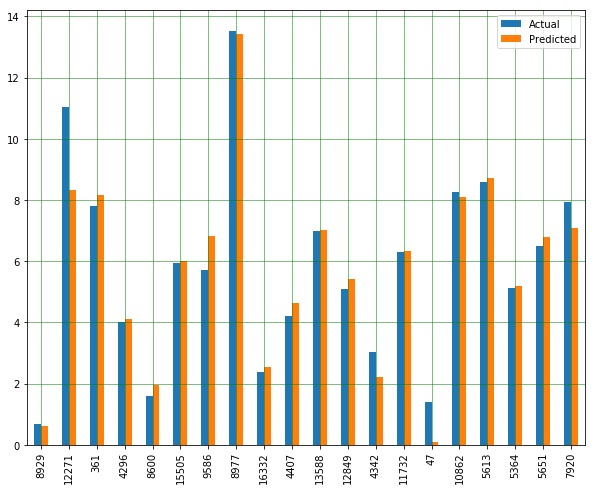

In [ ]:
df1=df_rfr.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Calculate the error for log-Cost


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels_reg, predictions_rfr))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels_reg, predictions_rfr))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels_reg, predictions_rfr)))

Mean Absolute Error: 0.35910229494130735
Mean Squared Error: 0.2962998459916919
Root Mean Squared Error: 0.5443343145454748


The Random Forest Regression model has the most accurate result!

Text(0.5, 1.0, 'Normal Q-Q Plot')

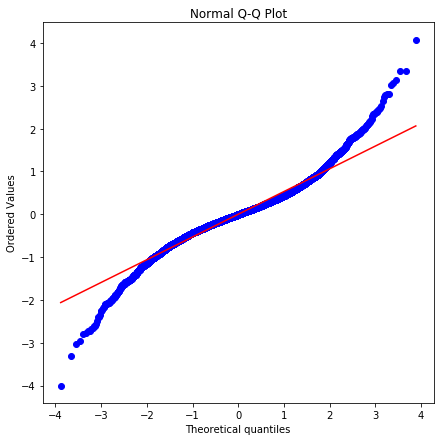

In [ ]:
prediction_rfr = rf.predict(train_features_reg)
residuals_rfr = train_labels_reg - prediction_rfr.reshape(-1)

plt.figure(figsize=(7,7))
stats.probplot(residuals_ridge, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

In [ ]:
idx_rfr=list(test_labels_reg.index)

### Retransform the log transformed 'Cost' : Smear Factor


In [ ]:
std_net = statistics.stdev(predictions_rfr)
predictions_rfr_real = list(map(lambda x: math.exp(x), predictions_rfr ))
test_rfr_real = df_dummy.Cost.iloc[idx_rfr]

### Calculate the error for retransformed Cost

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_rfr_real, predictions_rfr_real))  
print('Mean Squared Error:', metrics.mean_squared_error(test_rfr_real, predictions_rfr_real))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_rfr_real, predictions_rfr_real)))

Mean Absolute Error: 3392.082777411623
Mean Squared Error: 588313342.933759
Root Mean Squared Error: 24255.171467828444


### Check the importance of each variable

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(x.columns), importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[:10]

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Id                   Importance: 0.22
Variable: Dayparts_PRIME TIME  Importance: 0.13
Variable: Network_NBC          Importance: 0.05
Variable: Network_ESPN         Importance: 0.04
Variable: Network_FOX          Importance: 0.04
Variable: Network_MLB Network  Importance: 0.04
Variable: Network_Universal Kids Importance: 0.04
Variable: Duration             Importance: 0.03
Variable: Network_ABC          Importance: 0.03
Variable: Network_Universo     Importance: 0.03


### Find the accuracy !

In [ ]:
# Calculate the absolute errors
mu = np.mean(test_labels_reg)
test_labels_reg0 = [mu if x==0 else x for x in test_labels_reg]
predictions = rf.predict(test_features_reg)
errors_rfr = abs(predictions - np.array(test_labels_reg0))

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_rfr), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape_rfr = 100 * (errors_rfr / test_labels_reg0)

# Calculate and display accuracy
accuracy_rfr = 100 - np.mean(mape_rfr)
print('Accuracy(MAPE):', round(accuracy_rfr, 2), '%.')

Mean Absolute Error: 0.43 degrees.
Accuracy(MAPE): 91.34 %.


# 1.5.1. Random Forest Regression with scaled data

Since the Random Forest Regression model has the best result, I just wanted to try sclaed data to predict the cost...!!

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(x_train_scaled, y_train_scaled)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [ ]:
# Use the forest's predict method on the test data
predictions_rfr_sc = rf.predict(x_test_scaled)
# Calculate the absolute errors
errors = abs(predictions_rfr_sc - y_test_scaled)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.37 degrees.


In [ ]:
df_rfr_sc = pd.DataFrame({'Actual': y_test_scaled, 'Predicted': predictions_rfr_sc})
df_rfr_sc.head(10)

,Actual,Predicted
14868,8.356555,8.372565
14301,5.863631,5.867175
9691,1.609438,2.349417
6274,4.418841,4.287724
12593,5.398163,5.414966
51,6.122493,5.870797
1963,6.167516,5.913213
11503,5.924256,6.219136
5334,4.709530,4.681689
13206,6.608001,6.717275


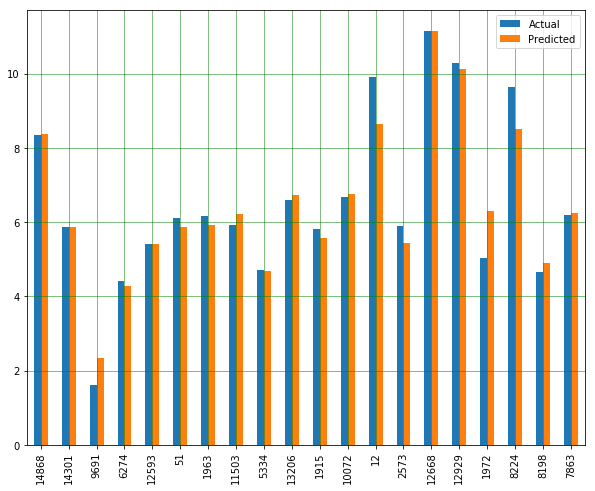

In [ ]:
df1=df_rfr_sc.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_scaled, predictions_rfr_sc))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_scaled, predictions_rfr_sc))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_scaled, predictions_rfr_sc)))

Mean Absolute Error: 0.36766295204390853
Mean Squared Error: 0.3140279449210311
Root Mean Squared Error: 0.5603819634151612


Unfortunately, it has worse accuracy than the Random Forest Regression model with the original dataset.

# 1.5.2. Random Forest Regression with compressed data

In [ ]:
rf.fit(df_pca_train, y_train_pca)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [ ]:
# Use the forest's predict method on the test data
predictions_rfr_pca = rf.predict(df_pca_test)
# Calculate the absolute errors
errors = abs(predictions_rfr_pca - y_test_pca)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 1.77 degrees.


In [ ]:
df_rfr_pca = pd.DataFrame({'Actual': y_test_pca, 'Predicted': predictions_rfr_pca})
df_rfr_pca.head(10)

,Actual,Predicted
14868,8.356555,6.378504
14301,5.863631,6.540903
9691,1.609438,6.494159
6274,4.418841,6.378042
12593,5.398163,6.475518
51,6.122493,6.291492
1963,6.167516,6.462562
11503,5.924256,6.304537
5334,4.709530,6.336310
13206,6.608001,6.058675


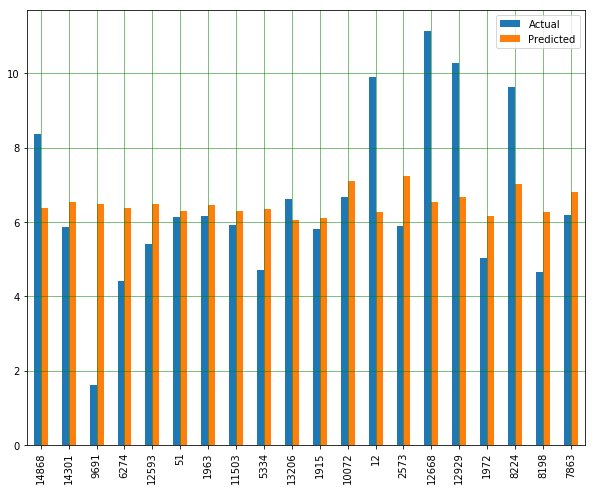

In [ ]:
df1=df_rfr_pca.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_pca, predictions_rfr_pca))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_pca, predictions_rfr_pca))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_pca, predictions_rfr_pca)))

Mean Absolute Error: 1.767717330509106
Mean Squared Error: 5.432629885150196
Root Mean Squared Error: 2.330800267107887


Unfortunately, it was worse accuracy than the Random Forest Regression model with the original dataset.

# 1.6. Gradient Boosting Regression

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [ ]:
GBoost.fit(train_features_reg, train_labels_reg)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=3000,
                          random_state=5)

In [ ]:
predictions_GBoost =GBoost.predict(test_features_reg)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels_reg, predictions_GBoost))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels_reg, predictions_GBoost))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels_reg, predictions_GBoost)))

Mean Absolute Error: 0.4549793505701891
Mean Squared Error: 0.4358328276309172
Root Mean Squared Error: 0.660176361005843


Worse than Random Forest Regression

# 1.7. XG Boosting Regression


In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
model_xgb.fit(train_features_reg, train_labels_reg)

[15:42:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
predictions_xgb =model_xgb.predict(test_features_reg)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels_reg, predictions_xgb))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels_reg, predictions_xgb))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels_reg, predictions_xgb)))

Mean Absolute Error: 0.4141781878144589
Mean Squared Error: 0.32634145004560067
Root Mean Squared Error: 0.5712630305258697


XG Boosting model is better than Gradient Boosting Regression, so I tried the model with scaled data.

# 1.7.1. XG Boosting Regression with Scaled Data


In [ ]:
model_xgb.fit(x_train_scaled, y_train_scaled)

[16:32:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
predictions_xgb_sc =model_xgb.predict(x_test_scaled)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels_reg, predictions_xgb_sc))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels_reg, predictions_xgb_sc))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels_reg, predictions_xgb_sc)))

Mean Absolute Error: 2.547462280568252
Mean Squared Error: 10.669597030406312
Root Mean Squared Error: 3.2664349113990183


Much less accurate than XG Boosting model trained by original dataset.

# 1.8. Stacking Model

The simplest stacking approach : Averaging base models

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [ ]:
averaged_models = AveragingModels(models = (rf, GBoost, regressor_ridge, model_xgb))

In [ ]:
averaged_models.fit(train_features_reg, train_labels_reg)

[17:06:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




AveragingModels(models=(RandomForestRegressor(n_estimators=1000,
                                              random_state=42),
                        GradientBoostingRegressor(learning_rate=0.05,
                                                  loss='huber', max_depth=4,
                                                  max_features='sqrt',
                                                  min_samples_leaf=15,
                                                  min_samples_split=10,
                                                  n_estimators=3000,
                                                  random_state=5),
                        Ridge(),
                        XGBRegressor(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_by...
                                     gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
  

In [ ]:
predictions_stack =averaged_models.predict(test_features_reg)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels_reg, predictions_stack))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels_reg, predictions_stack))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels_reg, predictions_stack)))

Mean Absolute Error: 0.3910923609148743
Mean Squared Error: 0.30676769319456454
Root Mean Squared Error: 0.5538661329189252


 It seems even the simplest stacking approach really improve the score compare to GBoosting method, Ridge regression, and XGboosing methods while Random Forest Regression method the most accurate model.

# Part 2: Classification

# 2.0. Data preparation for classification modeling

### Original data with dummy variables

In [ ]:
y = df_dummy.Cost_cat
x = df_dummy.drop(columns=["Cost", "Cost_log", "Cost_cat"], axis = 1)
train_features_cl, test_features_cl, train_labels_cl, test_labels_cl = train_test_split(x, y,
                                                                                test_size=0.2, random_state=0)

### Scaled data

In [ ]:
scaler.fit(x)
scaled_x = x.copy()
scaled_x.iloc[:] = scaler.transform(x)

In [ ]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(scaled_x, y, test_size=0.2, random_state=0)

### Compressed data

In [ ]:
pca_train = skd.PCA(n_components=230).fit_transform(x_train_scaled)
df_pca_train=pd.DataFrame(pca_train)

In [ ]:
pca_test = skd.PCA(n_components=230).fit_transform(x_test_scaled)
df_pca_test=pd.DataFrame(pca_test)
y_train_pca, y_test_pca = y_train_scaled, y_test_scaled

# 2.1. Random Forest Classification

In [ ]:
import sklearn.ensemble as skens
rf_model = skens.RandomForestClassifier(n_estimators=1000,oob_score=True, criterion='entropy')
rf_model.fit(train_features_cl,train_labels_cl)

RandomForestClassifier(criterion='entropy', n_estimators=1000, oob_score=True)

In [ ]:
predicted_labels = rf_model.predict(test_features_cl)
label_rf1 = pd.DataFrame(test_labels_cl).copy()
label_rf1['predicted_rf_tree'] = predicted_labels

In [ ]:
label_rf1

,Cost_cat,predicted_rf_tree
14868,Under 10k,Under 10k
14301,Under 10k,Under 10k
9691,Under 10k,Under 10k
6274,Under 10k,Under 10k
12593,Under 10k,Under 10k
...,...,...
7576,Under 10k,Under 10k
1098,10k,10k
9937,Under 10k,Under 10k
6918,Under 10k,Under 10k


In [ ]:
def accuracy(predicted_labels, test_labels):
    i=0
    for l in range(len(predicted_labels)):
        if predicted_labels[l]==list(test_labels)[l]:
            i+=1
    return i/len(predicted_labels)*100

In [ ]:
print("Accuracy of the Random Forest Calssification model is : ", accuracy(predicted_labels,test_labels_rfc),"%")

Accuracy of the Random Forest Calssification model is :  96.90014903129656 %


## Random Forest Classification with compressed data

In [ ]:
rf_model.fit(df_pca_train,y_train_pca)

RandomForestClassifier(criterion='entropy', n_estimators=1000, oob_score=True)

In [ ]:
predicted_labels_pca = rf_model.predict(df_pca_test)

In [ ]:
print("Accuracy of the Random Forest Calssification model is : ", accuracy(predicted_labels_pca,y_test_pca),"%")

Accuracy of the Random Forest Calssification model is :  90.52160953800298 %


## Random Forest Classification with Scaled Data

In [ ]:
rf_model.fit(x_train_scaled,y_train_scaled)

RandomForestClassifier(criterion='entropy', n_estimators=1000, oob_score=True)

In [ ]:
predicted_labels_sc = rf_model.predict(x_test_scaled)

In [ ]:
print("Accuracy of the Random Forest Calssification model is : ", accuracy(predicted_labels_sc,y_test_scaled),"%")

Accuracy of the Random Forest Calssification model is :  96.8107302533532 %


# 2.2. KNN Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_features_cl, train_labels_cl)

KNeighborsClassifier()

In [ ]:
predicted_labels_Knn = classifier.predict(test_features_cl)

In [ ]:
print("Accuracy of the KNN Calssification model is : ", accuracy(predicted_labels_Knn,test_labels_cl),"%")

Accuracy of the KNN Calssification model is :  95.70789865871832 %


### With Scaled Data

In [ ]:
classifier.fit(x_train_scaled, y_train_scaled)

KNeighborsClassifier()

In [ ]:
predicted_labels_Knn_sc = classifier.predict(x_test_scaled)

In [ ]:
print("Accuracy of the KNN Calssification model is : ", accuracy(predicted_labels_Knn_sc,test_labels_cl),"%")

Accuracy of the KNN Calssification model is :  96.15499254843517 %


### With Dimension Reduced Data

In [ ]:
classifier.fit(df_pca_train, y_train_pca)

KNeighborsClassifier()

In [ ]:
predicted_labels_Knn_pca = classifier.predict(df_pca_test)

In [ ]:
print("Accuracy of the KNN Calssification model is : ", accuracy(predicted_labels_Knn_pca,y_test_pca),"%")

Accuracy of the KNN Calssification model is :  90.13412816691505 %
